# 2020 Presidential Election Time Series
## Project Setup

In [50]:
%run get_data.py

Repo: 'origin': https://github.com/ElectProject/Early-Vote-2020G.git
Total commits: 1423
docs/index.html commits: 650


,commit,datetime,vote_id,vote_total,request_id,request_total
1,ea56bb2fe920d96f19508263b6bbf258a2c44405,2020-11-03 15:37:00-05:00,total-voted,101167740,mail-ballots-requested,92102813
3,350cf23f5f3ffc55cd369d1631a56f159509e021,2020-11-03 14:14:00-05:00,total-voted,100978567,mail-ballots-requested,92074453
5,ed7fe766f1957e45d61486c37dd0c77446cafdd6,2020-11-03 13:41:00-05:00,total-voted,100831066,mail-ballots-requested,92074453
7,855537901ce1c3a420af566fcb964e60848889e0,2020-11-03 12:56:00-05:00,total-voted,100796871,mail-ballots-requested,92074453
9,a0cd920ffd59b15575ca4e3daaef0753652291ac,2020-11-03 12:17:00-05:00,total-voted,100611070,mail-ballots-requested,92074453
...,...,...,...,...,...,...
645,55ef4d8da4c860460a99cff8d2e7dac0605a857d,2020-09-01 22:55:00-04:00,NaN,NaN,NaN,12743272
646,ff3f92d8e11b8a23335cddf64e5799c74912ec52,2020-09-01 22:08:00-04:00,NaN,NaN,NaN,12623324
647,52ba37e4bd3605ab83b71358536ddf26d54b395d,2020-09-01 20:43:00-04:00,NaN,NaN,national-statistics,12623324
648,d34181643d565305eff7486090acbe9329c48d31,2020-09-01 15:48:00-04:00,NaN,NaN,national-statistics,12623324


,datetime,vote_total_2016
0,2020-09-25 22:59:00-04:00,9525
1,2020-10-02 22:59:00-04:00,74836
2,2020-10-09 22:59:00-04:00,429337
3,2020-10-16 22:59:00-04:00,1400000
4,2020-10-23 22:59:00-04:00,5900000
5,2020-10-30 22:59:00-04:00,21000000
6,2020-11-02 22:59:00-05:00,46220922
7,2020-11-03 22:59:00-05:00,136452150


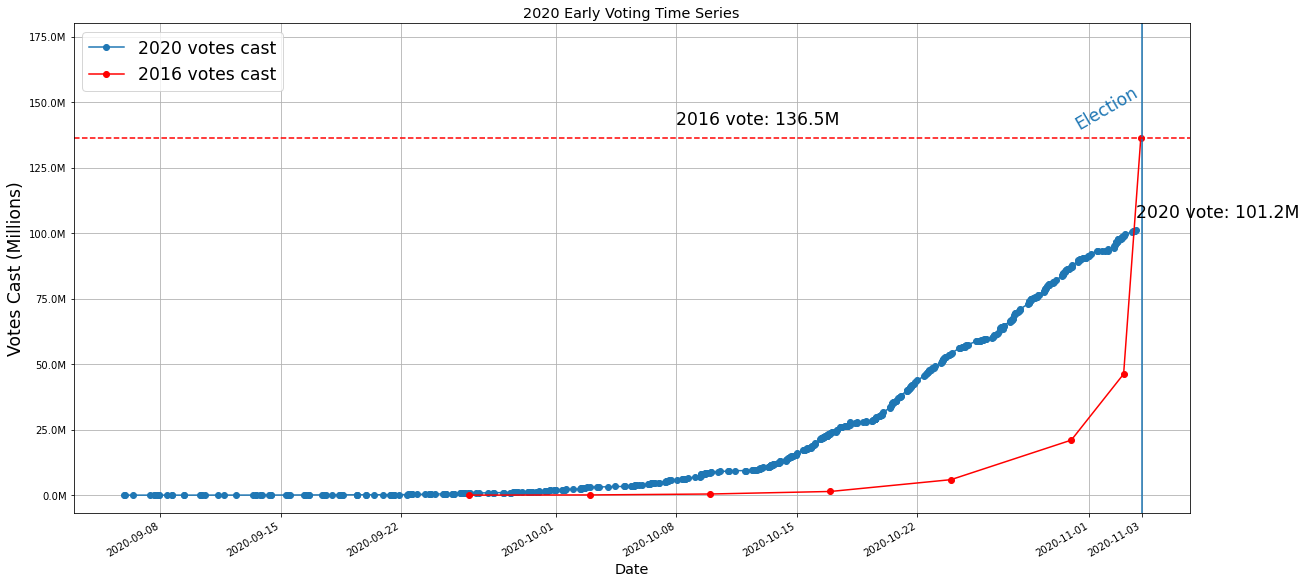

Loading BokehJS ...

In [51]:
update_notebook()